# Alexnet Model

Make a model based on the architecture of AlexNet


## Importing Moduels

In [44]:
import torch
import numpy as np
from torch import nn,optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [45]:
device = torch.cuda.is_available()

# Checking CUDA 
if device: print('CUDA available. Training on GPU')
else: print("CUDA is not available. Training on CPU")

CUDA available. Training on GPU


## Creating Datasets

In [31]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader


batch_size = 20

valid_size = 0.2

transform = transforms.Compose([
                                transforms.Resize((227,227)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ])

train_data = datasets.CIFAR10('data',train = True,download= True, transform = transform)
test_data = datasets.CIFAR10('data',train = False,download= True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [46]:
np.random.seed(10) #seed (can or cannot be included depends on user) to maintain uniformity in randomness
train_num = len(train_data)
indices = list(range(train_num))
np.random.shuffle(indices)

split = int(np.floor(valid_size*train_num))
train_idx,valid_idx = indices[split:], indices[:split]

In [33]:
# Making loaders for the dataset

train_sampler  = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset=train_data,batch_size = batch_size, sampler = train_sampler, num_workers=0 )
valid_loader = DataLoader(dataset=train_data,batch_size = batch_size, sampler = valid_sampler, num_workers=0 )
test_loader = DataLoader(dataset=test_data,batch_size = batch_size, num_workers=0 )


#Classes of CIFAR10 dataset
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

## Image Visualisation

In [47]:
def imshow(img):
    # img = img.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

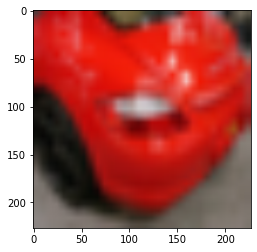

In [48]:
dataiter = iter(train_loader)
images,labels = next(dataiter)

images.numpy()
imshow(images[0])

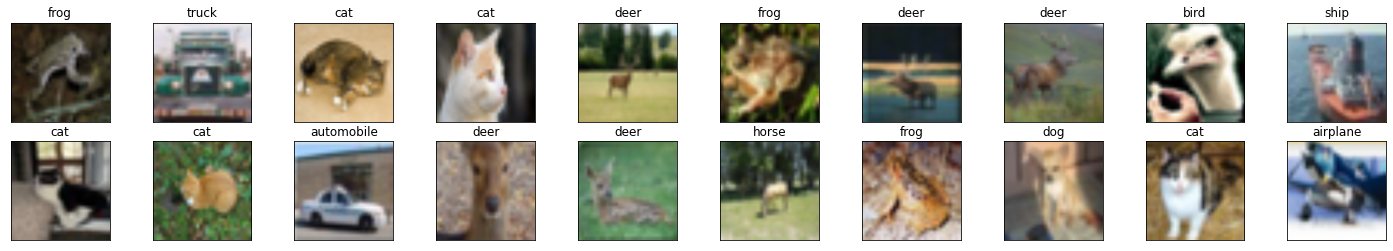

In [49]:
dataiter = iter(train_loader)
images , labels = dataiter.next()

fig = plt.figure(figsize = (25,4))
for i in range(batch_size):
    sub = fig.add_subplot(2,10,i+1,xticks=[],yticks = [])
    sub.set_title(classes[labels[i]])
    imshow(images[i])

## AlexNet Model Architecture


This is the [AlexNet Architecture](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/) in table form.:


Convolutional Layers
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-19-16-01-03.png)

Dropout and Fully Connected Layers
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-19-16-01-13.png)

Last 2 fully connected layers are modified. As the general architecture of AlexNet gives us an output of 1000 classification layers, but CIFAR10 has only 10 classes, so I have modified the layers accordingly:

---

> Last 2 Layers


*  FC2 (Fully Connected 2 Layer) has (input, output) ➡ (4096,500)

*  FC3 (Fully Connected 3 Layer) has (input, output) ➡ (500,10)
---

So the final architecture is as follows:

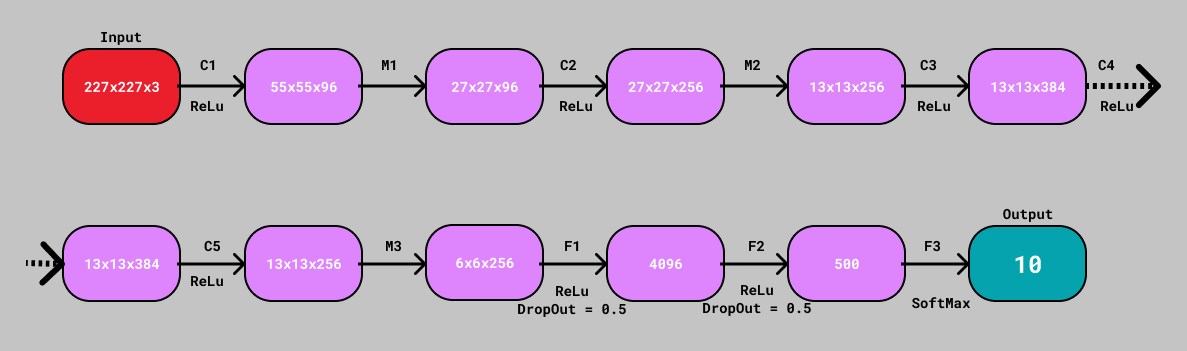


The following layers arguments can be seen in the code. For example you can see the number of filters and kernel size of C1 in the code cell below. I did not find any space in the flowchart above to fit data of each layer. But they do have what is the activation and dropout for each layers.

I have written Last Layer to have activation of Softmax, but I didn't apply any as, my criterion is [nn.CrossEntopyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which applies log softmax function and nllloss to the last layer. You can find more about Cross Entropy Loss, in the link for the documentation above.

In [50]:
#Adjusting last layers to give output 10 classifications

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.C1 = nn.Conv2d(3,96,kernel_size= 11, stride= 4)
        self.M1 = nn.MaxPool2d(kernel_size=3,stride=2)
        self.C2 = nn.Conv2d(96,256,kernel_size = 5, stride = 1, padding =2)
        self.M2 = nn.MaxPool2d(kernel_size = 3,stride = 2)
        self.C3 = nn.Conv2d(256,384,kernel_size = 3,stride =1,padding=1)
        self.C4 = nn.Conv2d(384,384,kernel_size = 3,stride =1,padding=1)
        self.C5 = nn.Conv2d(384,256,kernel_size = 3,stride =1,padding=1)
        self.M3 = nn.MaxPool2d(kernel_size = 3,stride = 2)
        self.drop = nn.Dropout( p = 0.5)
        self.F1 = nn.Linear(6*6*256,4096)
        self.F2 = nn.Linear(4096,500)
        self.F3 = nn.Linear(500,10)

    def forward(self,x):
        x = F.relu(self.C1(x))
        x = self.M1(x)
        x = F.relu(self.C2(x))
        x = self.M2(x)
        x = F.relu(self.C3(x))
        x = F.relu(self.C4(x))
        x = F.relu(self.C5(x))
        x = self.M3(x)
        x = torch.flatten(x,1)
        x = self.drop(x)
        x = F.relu(self.F1(x))
        x = self.drop(x)
        x = F.relu(self.F2(x))
        x = self.F3(x)

        return x

model = AlexNet()

if device:
    model.cuda()

print(model)


AlexNet(
  (C1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (M1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (M2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (M3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (F1): Linear(in_features=9216, out_features=4096, bias=True)
  (F2): Linear(in_features=4096, out_features=500, bias=True)
  (F3): Linear(in_features=500, out_features=10, bias=True)
)


## Training, Criterion and Optimizer

In [51]:
crit = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr = 0.01)

In [64]:
epochs = 10

# valid_min_loss = np.Inf

if device:
    print("Training In CUDA")
else:
    print("Training In CPU")

for e in range(epochs):
    model.train()
    train_loss = 0.0
    valid_loss = 0.0

    for images, labels in train_loader:
        if device:
            images,labels = images.cuda(),labels.cuda()
        opt.zero_grad()

        out = model(images)

        loss = crit(out,labels)

        loss.backward()

        opt.step()

        train_loss += loss.item()*images.size(0)

    
    model.eval()

    for images,labels in valid_loader:
        if device:
            images,labels = images.cuda(),labels.cuda()

        out = model(images)

        loss = crit(out,labels)

        valid_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    print("Epoch{} \t Training Loss: {:0.6f} \t Validation Loss: {:0.6f}".format(e+1,train_loss,valid_loss))

    if valid_loss <= valid_min_loss:
        print("Validation Loss Decreased \t {:0.6f} ---> {:0.6f} \t Saving Model....".format(
            valid_min_loss, valid_loss
        ))
        torch.save(model.state_dict(),'AlexNet.pt')
        valid_min_loss = valid_loss


Training In CUDA
Epoch1 	 Training Loss: 0.529448 	 Validation Loss: 0.131952
Validation Loss Decreased 	 0.143722 ---> 0.131952 	 Saving Model....
Epoch2 	 Training Loss: 0.477124 	 Validation Loss: 0.123347
Validation Loss Decreased 	 0.131952 ---> 0.123347 	 Saving Model....
Epoch3 	 Training Loss: 0.433676 	 Validation Loss: 0.116630
Validation Loss Decreased 	 0.123347 ---> 0.116630 	 Saving Model....
Epoch4 	 Training Loss: 0.387163 	 Validation Loss: 0.116703
Epoch5 	 Training Loss: 0.353814 	 Validation Loss: 0.105220
Validation Loss Decreased 	 0.116630 ---> 0.105220 	 Saving Model....
Epoch6 	 Training Loss: 0.317287 	 Validation Loss: 0.122644
Epoch7 	 Training Loss: 0.282876 	 Validation Loss: 0.106389
Epoch8 	 Training Loss: 0.250329 	 Validation Loss: 0.110204
Epoch9 	 Training Loss: 0.224552 	 Validation Loss: 0.107685
Epoch10 	 Training Loss: 0.200372 	 Validation Loss: 0.109625


**Loading the best Model, with minimum validation loss.**

In [65]:
model.load_state_dict(torch.load('AlexNet.pt'))

<All keys matched successfully>

## Testing the Model, and **ACCURACY**

In [66]:
# # # Accuracy
model.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

test_loss = 0.0
for images,labels in test_loader:
    if device:
        images,labels = images.cuda(),labels.cuda()
    out = model(images)
    loss = crit(out,labels)

    test_loss += loss.item() * images.size(0)

    _,pred = torch.max(out,1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(batch_size):
        tar = labels.data[i]
        class_correct[tar] += correct[i].item()
        class_total[tar] += 1

test_loss /= len(test_loader.dataset)
print("Test Loss: {:0.6f}".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print("Test Accuracy of {}: {}% \t ({}/{})".format(
            classes[i], 100* class_correct[i]/class_total[i],np.sum(class_correct[i]),np.sum(class_total[i])
        ))

    else:
        print("Test Accuracy of {}: N/A (Not Available)".format(classes[i]))
    

print("\n Average Test Accuracy: {}% \t ({}/{})".format(
    100*np.sum(class_correct)/np.sum(class_total),np.sum(class_correct),np.sum(class_total)
))



Test Loss: 0.547444
Test Accuracy of airplane: 88.0% 	 (880.0/1000.0)
Test Accuracy of automobile: 88.4% 	 (884.0/1000.0)
Test Accuracy of bird: 74.6% 	 (746.0/1000.0)
Test Accuracy of cat: 66.8% 	 (668.0/1000.0)
Test Accuracy of deer: 81.7% 	 (817.0/1000.0)
Test Accuracy of dog: 68.6% 	 (686.0/1000.0)
Test Accuracy of frog: 83.9% 	 (839.0/1000.0)
Test Accuracy of horse: 84.0% 	 (840.0/1000.0)
Test Accuracy of ship: 90.6% 	 (906.0/1000.0)
Test Accuracy of truck: 86.9% 	 (869.0/1000.0)

 Average Test Accuracy: 81.35% 	 (8135.0/10000.0)


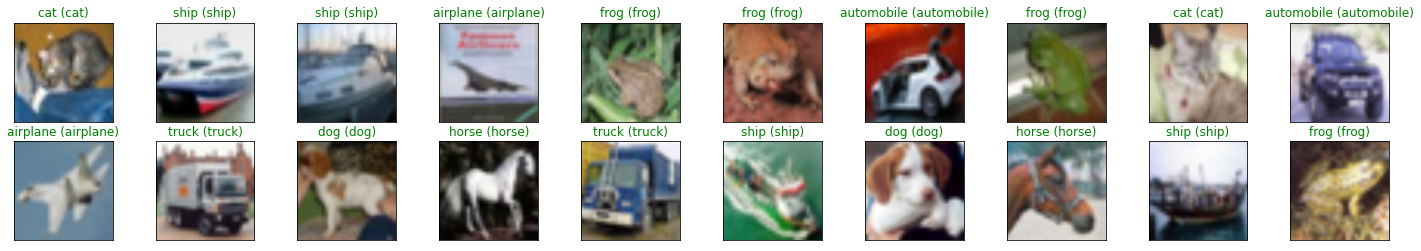

In [68]:
test_iter = iter(test_loader)

images,labels = test_iter.next()
# images = images.numpy()
model.eval()
# display(images)
images.numpy()
if device:
    images = images.cuda()

# display(images.cpu())
out = model(images)
_, pred = torch.max(out,1)
# display(pred)

fig = plt.figure(figsize = [25,4])
# plt.title("Hello",fontsize=20)
for i in range(batch_size):
    ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    imshow(images[i] if not device else images[i].cpu())

    ax.set_title("{} ({})".format(classes[pred[i]],classes[labels[i]]),
                    color = ("green" if pred[i] == labels[i].item() else "red"))

In [69]:
from torchsummary import summary

summary(model,(3,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
         MaxPool2d-2           [-1, 96, 27, 27]               0
            Conv2d-3          [-1, 256, 27, 27]         614,656
         MaxPool2d-4          [-1, 256, 13, 13]               0
            Conv2d-5          [-1, 384, 13, 13]         885,120
            Conv2d-6          [-1, 384, 13, 13]       1,327,488
            Conv2d-7          [-1, 256, 13, 13]         884,992
         MaxPool2d-8            [-1, 256, 6, 6]               0
           Dropout-9                 [-1, 9216]               0
           Linear-10                 [-1, 4096]      37,752,832
          Dropout-11                 [-1, 4096]               0
           Linear-12                  [-1, 500]       2,048,500
           Linear-13                   [-1, 10]           5,010
Total params: 43,553,542
Trainable para